In [77]:
import astropy as ap
from astropy.io import fits
import numpy as np

In [37]:
fname="https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2020/bn%s/current/glg_ctime_n%i_bn%s_v00.pha" #NaI det spectra
alldets=[]
bid="200412381"
good=[]
for ndet in range(12):
    try:
        dd=fits.getdata(fname%(bid,ndet,bid),ext=2)
    except:
        continue
    good.append(ndet)
    times=np.array([d[3] for d in dd])
    allcurves=np.array([d[0] for d in dd]).T
    alldets.append(np.array([times]+list(allcurves)))

In [23]:
expo=det[0][1:]-det[0][:-1]
sel=(expo>0.05)*(expo<0.15)
tran=np.where(sel)[0][[0,-1]]
tsel=slice(tran[0],tran[1])

In [27]:
tmaxes=[np.argmax(det[1:,tsel].sum(0)) for det in alldets]
tmaxes

[139, 4829, 3055, 150, 147, 148, 150, 149, 151, 148]

In [36]:
basel=[det[1:,tran[1]-200:tran[1]-2].sum(0).mean() for det in alldets]
bastd=[det[1:,tran[1]-200:tran[1]-2].sum(0).std() for det in alldets]
bastd

[7.643208145272775,
 8.47498374359133,
 8.036431179284596,
 9.305904698574619,
 8.318623380673928,
 8.622649930697904,
 7.284775374009169,
 7.881534421562962,
 6.970882639596147,
 9.16814691557263]

In [42]:
maxig=[alldets[i][1:,tsel][:,tmaxes[i]].sum()-basel[i] for i in range(10)]
sigma=np.array(maxig)/bastd
np.array(good)[sigma>30]

array([3, 6, 7, 8, 9])

In [69]:
det[0,tsel][150]-t0

141.30689799785614

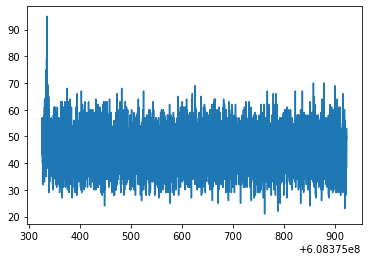

In [43]:
import matplotlib.pyplot as pl
%matplotlib inline

det=alldets[3]
pl.plot(det[0][tsel],det[1:4,tsel].sum(0))

In [44]:
fname3="https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2020/bn%s/current/glg_tte_n%i_bn%s_v00.fit"
dsel=[6,7,8,9]
mulist=[fits.getdata(fname3%(bid,d,bid),ext=2) for d in dsel]


In [45]:
[m.shape for m in mulist]

[(610409,), (646273,), (579986,), (652860,)]

In [123]:
tevs=np.load("det6.npz")['time']
tevs[z0:][:100]

array([89.9693  , 89.97569 , 89.976105, 89.97805 , 89.97905 , 89.97963 ,
       89.98186 , 89.98356 , 89.98872 , 89.99036 , 89.99091 , 89.99108 ,
       89.99115 , 89.99142 , 89.99142 , 89.991936, 89.99271 , 89.994736,
       89.99611 , 89.99637 , 89.997925, 89.99866 , 90.000275, 90.002945,
       90.00398 , 90.004944, 90.006805, 90.00695 , 90.00699 , 90.00723 ,
       90.00741 , 90.00768 , 90.00783 , 90.00817 , 90.01046 , 90.01259 ,
       90.013954, 90.01411 , 90.0161  , 90.01842 , 90.01919 , 90.02016 ,
       90.02016 , 90.02073 , 90.02313 , 90.025345, 90.025604, 90.02772 ,
       90.02829 , 90.02964 , 90.0312  , 90.032974, 90.033775, 90.03544 ,
       90.03607 , 90.03671 , 90.04172 , 90.04198 , 90.04281 , 90.044235,
       90.047035, 90.04805 , 90.04864 , 90.048645, 90.04889 , 90.051544,
       90.052605, 90.0528  , 90.05315 , 90.05355 , 90.054955, 90.055405,
       90.05613 , 90.05631 , 90.0572  , 90.05972 , 90.062675, 90.062775,
       90.0637  , 90.06508 , 90.06538 , 90.0657  , 

In [117]:
mulist[0]['TIME'][z0+1]-t0

89.97569394111633

In [122]:
[np.savez("det%i.npz"%(6+i),time=(m['TIME']-t0).astype(np.float32),pha=m['PHA'].astype('i8')) for i,m in enumerate(mulist)]
#from imp import reload 
#import evlist_corr
#reload(evlist_corr)

[None, None, None, None]

In [62]:
inp2=np.load("det6.npz")
abs(inp['time']-inp2['time']).max()

0.0

In [181]:
from evlist_corr import *
t0=608375194
tmax=140
tevs=np.load("det7.npz")['time']
tevs2=np.load("det8.npz")['time']
qr=np.arange(len(tevs))
z0=qr[tevs>=tmax-40][0]
z1=qr[tevs>=tmax+40][0]
#z0=sum(tevs<tmax-40)
qr=np.arange(len(tevs2))
z20=qr[tevs2>=tmax-40][0]
z21=qr[tevs2>=tmax+40][0]
#z20=sum(tevs2<tmax-40)
#z21=sum(tevs2<tmax+40)
z1-z0,z21-z20

(126869, 116617)

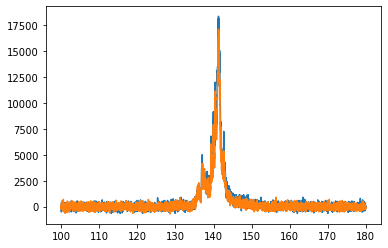

In [182]:
dt,k,l=0,0,0
subsam=5
fac=50
sel2=slice(z0+k,z1,subsam)
bin1,cur1=lcurve(tevs[z0:z1],fac,-2*fac,tstart=90)
bin2,cur2=lcurve(tevs2[z20:z21]+dt,fac,-2*fac,tstart=90)
nor1,nor2=1/cur1.sum(),1/cur2.sum()
pl.plot(bin1,cur1)
pl.plot(bin2,cur2)

In [216]:
#import extra
def clipped(val,nsig=3.,nclip=1,loud=0,rep=0):
    '''clipped average'''
    from numpy import bool,ones
    sel=ones(val.shape,bool)
    rcheck=False
    nold=len(val)
    if nclip<0: 
        nclip=nold
        rcheck=True
    for i in range(nclip):
        avg=val[sel].mean()
        std=val[sel].std()
        if loud>0: print("selecting %f +- %f"%(avg,std*nsig))
        sel=abs(val-avg)<std*nsig
        if rcheck:
            nnew=sum(sel)
            if nnew==nold: break # no sense of repeating
            nold=nnew
    if rep==1: return val[sel].min(),val[sel].max()
    return sel
vals=gres2[:,2].reshape(nshi,subsam**2)[3]
def randids(z0=0,z1=100,frac=5):
    slen=(z1-z0)//frac
    return z0+np.random.randint(frac,size=slen)+frac*np.arange(slen)
#clipped(vals,nclip=3)

In [292]:
def onetest(ev1,ev2,fac,tstart=110,do_fit=True):
    bin1,cur1=lcurve(ev1,fac,-2*fac,tstart=tstart)
    bin2,cur2=lcurve(ev2,fac,-2*fac,tstart=tstart)
    nor1,nor2=1/cur1.sum(),1/cur2.sum()
    cwin1=cur1[(qmid-qsiz)*fac:(qmid+qsiz)*fac]
    cwin2=cur2[:qful*fac]
    cfunc=np.correlate(cwin1*nor1,cwin2*nor2,"valid")
    if do_fit:
        try:
            res=[fit_corr(cfunc,doplot=False,inifac=fac/100,cmax=cent)[0]-cent]
        except:
            res=[0]
    else:
        res=[0]
    res+=list(wcent(cfunc,nbin=5)-cent)
    res+=[cfunc.max(),cwin1.max(),cwin2.max(),np.argmax(cwin1),np.argmax(cwin2)]
    return res

qmid,qsiz=34,12
qful=2*qmid
def multest(tevs,tevs2,niter=50,fac=50,subsam=10,nshi=10,randomize=True,do_fit=False):
    #selecting every subsam event
    #shifting wrt. binning
    cent=(qmid-qsiz)*fac
    
    gres2=[]
    if randomize:
        for m in range(niter):
            ev1=tevs[randids(z0,z1,subsam)]
            ev2=tevs2[randids(z20,z21,subsam)]
            for dt in np.r_[0:1./fac:nshi*1j]:
                gres2.append(onetest(ev1+dt,ev2+dt,fac,do_fit=do_fit))
    else:
        for k in range(subsam):
            for l in range(subsam):
                sel2=slice(z0+k,z1,subsam)
                sel22=slice(z20+l,z21,subsam)
                gres2.append(onetest(tevs[sel2]+dt,tevs2[sel22]+dt,fac,do_fit=do_fit))         
    return np.array(gres2)

#[np.std(np.median(gres2[:,i].reshape(nshi,subsam**2),0))/fac*1e3 for i in range(0,5)]
gres2=multest(tevs,tevs2,50,nshi=20)

[np.std(np.median(gres2[:,i].reshape(len(gres2)//nshi,nshi),1))/fac*1e3 for i in range(0,5)]

[0.0,
 3.7256357692066424,
 7.678326086964053,
 10.820683176530071,
 15.701784099868561]

In [ ]:
mes=[]
for 
mes.append([np.std(np.median(gres2[:,i].reshape(len(gres2)//nshi,nshi),1))/fac*1e3 for i in range(0,5)])

In [272]:
i=1
nshi=20
pok=gres2[:,i].reshape(len(gres2)//nshi,nshi)
pok[3]

array([-0.74419698, -0.48356043, -0.41866004, -0.10943079, -0.05271028,
       -0.35659406, -0.29317197, -0.11072288, -0.35512961, -0.29197291,
       -0.3536306 , -0.16839592, -0.05096032,  0.2872583 ,  0.00359485,
       -0.35333398, -0.29151437, -0.41841295, -0.86859467, -0.74419539])

In [279]:
pok2=[p[clipped(p,nsig=2,nclip=2)] for p in pok]
np.std([np.median(p) for p in pok2])/fac*1e3,np.std([np.median(p) for p in pok])/fac*1e3

(2.849612785356208, 2.841663085699764)

### testing different eventlist combinations 
(NaI detectors 6-9)


In [283]:
alldat={}
allrang={}
for i in range(6,10):
    alldat[i]=np.load("det%i.npz"%i)['time']
    qr=np.arange(len(alldat[i]))
    allrang[i]=[qr[alldat[i]>=tmax-40][0],qr[alldat[i]>=tmax+40][0]]
    

#### timebin 10 ms (fac=100)

In [312]:
mes=[]
fac=100
nshi=10
for i in range(6,9):
    for j in range(i+1,10):
        tevs,tevs2=alldat[i],alldat[j]
        z0,z1=allrang[i]#,alldat[j]#qr[tevs>=tmax-40][0],qr[tevs>=tmax+40][0]
        z20,z21=allrang[j]
        gres2=multest(tevs,tevs2,fac,nshi=nshi, do_fit=False)
        cumsel=1 #narrow region around maximum
        medpos=np.median(gres2[:,cumsel].reshape(len(gres2)//nshi,nshi),1)/fac*1e3
        rep=[np.std(medpos)]+list(np.percentile(medpos,[10,90]))
        rep+=list(np.percentile(gres2[:,cumsel].ravel(),[10,90])/fac*1e3)
        mes.append(rep)
(np.array(mes)*1e3).astype(int)

array([[  1036, -13996, -11409, -14635,  -9470],
       [  2099, -11212,  -6230, -13641,  -3051],
       [  2383, -11920,  -5740, -14137,  -2792],
       [  1393,  -1725,   1595,  -4183,   3205],
       [  1558,  -1681,   2428,  -3992,   3929],
       [  2508,  -8421,  -1572, -10656,    489]])

#### timebin 20 ms (fac=50)

In [310]:
mes2=[]
fac=50
for i in range(6,9):
    for j in range(i+1,10):
        tevs,tevs2=alldat[i],alldat[j]
        z0,z1=allrang[i]#,alldat[j]#qr[tevs>=tmax-40][0],qr[tevs>=tmax+40][0]
        z20,z21=allrang[j]
        gres2=multest(tevs,tevs2,fac,nshi=nshi, do_fit=False)
        cumsel=1 #narrow region around maximum
        medpos=np.median(gres2[:,cumsel].reshape(len(gres2)//nshi,nshi),1)/fac*1e3
        rep=[np.std(medpos)]+list(np.percentile(medpos,[10,90]))
        rep+=list(np.percentile(gres2[:,cumsel].ravel(),[10,90])/fac*1e3)
        mes2.append(rep)
(np.array(mes2)*1e3).astype(int)

array([[  2192, -28328, -22806, -29376, -18945],
       [  3386, -22962, -14520, -27243,  -7520],
       [  4107, -24907, -13743, -27685,  -8536],
       [  3093,  -4059,   3680,  -8397,   6408],
       [  2858,  -2701,   4316,  -7942,   7108],
       [  4258, -16063,  -3861, -21294,    920]])

#### timebin 5 ms (fac=200)

In [313]:
mes3=[]
fac=200
for i in range(6,9):
    for j in range(i+1,10):
        tevs,tevs2=alldat[i],alldat[j]
        z0,z1=allrang[i]#,alldat[j]#qr[tevs>=tmax-40][0],qr[tevs>=tmax+40][0]
        z20,z21=allrang[j]
        gres2=multest(tevs,tevs2,fac,nshi=nshi, do_fit=False)
        cumsel=1 #narrow region around maximum
        medpos=np.median(gres2[:,cumsel].reshape(len(gres2)//nshi,nshi),1)/fac*1e3
        rep=[np.std(medpos)]+list(np.percentile(medpos,[10,90]))
        rep+=list(np.percentile(gres2[:,cumsel].ravel(),[10,90])/fac*1e3)
        mes3.append(rep)
(np.array(mes3)*1e3).astype(int)

array([[  589, -7071, -5652, -7316, -4736],
       [ 1145, -5876, -3126, -6829, -1869],
       [ 1012, -6084, -3447, -6910, -2130],
       [  819, -1000,  1020, -2096,  1742],
       [  749,  -679,  1103, -1996,  1958],
       [ 1002, -3679, -1153, -5019,   244]])

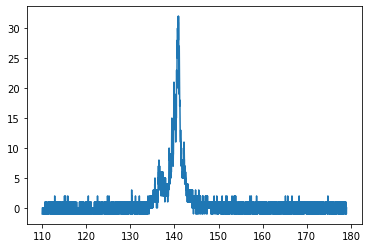

In [281]:
ev1=tevs[randids(z0,z1,subsam)]
bin1,cur1=lcurve(ev1,fac,-2*fac,tstart=110)
pl.plot(bin1,cur1/fac)

In [240]:
[np.std(np.median(gres2[:,i].reshape(nshi,50),0))/fac*1e3 for i in range(0,5)]

[41.757131218974884,
 2.3319603156508872,
 5.360105574098808,
 7.749381303627726,
 11.107511880713224]

2.1559087316092937

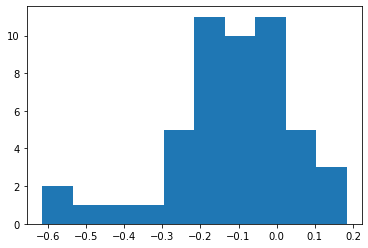

In [251]:
#pl.hist(gres2[:,1].ravel())
set1=np.median(gres2[:,1].reshape(len(gres2)//nshi,nshi),1)
pl.hist(set1)
np.std(set1[clipped(set1,nsig=2,nclip=2)])*1e3/fac

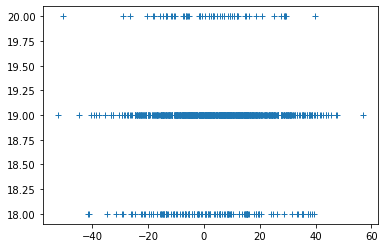

In [229]:
pl.plot(gres2[:,0],gres2[:,-4]/fac,'+')

#### hokus pokus

In [169]:
#import astroquery
from astroquery.heasarc import Heasarc
heasarc = Heasarc()

In [ ]:
mission=b'fermigbrst'
from astropy.coordinates import SkyCoord
from astropy import units as u
coords = SkyCoord('12h00m00s +04d12m06s', frame='icrs')
table = heasarc.query_region(coords, mission=mission, radius=120*u.arcmin)#,format='pandas.csv')
#heasarc.query()

In [ ]:
|